# Baseline ML Models (Task 2.1)

This notebook builds baseline machine learning models to predict earnings move magnitude and direction.

**Models:**
1. **Linear Regression**: Predict absolute move percentage (magnitude)
2. **Logistic Regression**: Predict move direction (up/down)
3. **Simple Ensemble**: Combine both predictions

**Validation Strategy:**
- Walk-forward cross-validation (time-series aware)
- Train on past data, validate on future data
- Multiple folds to assess stability

**Success Metrics:**
- Magnitude: MAE, RMSE, R²
- Direction: Accuracy, Precision, Recall, F1
- Combined: Trading strategy simulation (win rate, Sharpe ratio)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load and Prepare Data

In [2]:
# Load merged features
features_df = pd.read_parquet('../data/features/all_features.parquet')

print(f"Loaded features shape: {features_df.shape}")
print(f"Date range: {features_df['earnings_date'].min()} to {features_df['earnings_date'].max()}")
print(f"Unique tickers: {features_df['ticker'].nunique()}")

# Check target availability
target_magnitude = 'current_abs_move_pct'
target_direction = 'current_close_move_pct'

print(f"\nTarget columns:")
print(f"  Magnitude: {target_magnitude} - {features_df[target_magnitude].notna().sum()} non-null")
print(f"  Direction: {target_direction} - {features_df[target_direction].notna().sum()} non-null")

Loaded features shape: (4926, 83)
Date range: 2007-07-18 00:00:00 to 2025-11-19 00:00:00
Unique tickers: 385

Target columns:
  Magnitude: current_abs_move_pct - 4926 non-null
  Direction: current_close_move_pct - 4926 non-null


In [3]:
# Identify feature columns (exclude meta and target columns)
exclude_cols = ['ticker', 'earnings_date', target_magnitude, target_direction, 
                'earnings_frequency', 'vix_regime', 'market_regime']

feature_cols = [col for col in features_df.columns if col not in exclude_cols]

print(f"\nFeature columns: {len(feature_cols)}")
print(f"\nFeature categories:")
print(f"  Historical: {len([c for c in feature_cols if 'hist_' in c])}")
print(f"  Volatility: {len([c for c in feature_cols if any(x in c for x in ['atr_', 'bb_', 'hv_', 'vol_'])])}")
print(f"  Market: {len([c for c in feature_cols if any(x in c for x in ['vix_', 'spy_', 'qqq_', 'market'])])}")
print(f"  Time: {len([c for c in feature_cols if any(x in c for x in ['days_', 'month_', 'quarter', 'is_', 'years_', 'historical_earnings'])])}")


Feature columns: 76

Feature categories:
  Historical: 24
  Volatility: 16
  Market: 11
  Time: 14


In [4]:
# Prepare dataset - remove rows with missing targets
df_clean = features_df.dropna(subset=[target_magnitude, target_direction]).copy()

print(f"\nClean dataset: {len(df_clean)} rows (removed {len(features_df) - len(df_clean)} rows with missing targets)")

# Create direction binary target (1 = up, 0 = down)
df_clean['direction_binary'] = (df_clean[target_direction] > 0).astype(int)

print(f"\nDirection distribution:")
print(f"  Up (1): {df_clean['direction_binary'].sum()} ({df_clean['direction_binary'].sum()/len(df_clean)*100:.1f}%)")
print(f"  Down (0): {(~df_clean['direction_binary'].astype(bool)).sum()} ({(~df_clean['direction_binary'].astype(bool)).sum()/len(df_clean)*100:.1f}%)")


Clean dataset: 4926 rows (removed 0 rows with missing targets)

Direction distribution:
  Up (1): 4917 (99.8%)
  Down (0): 9 (0.2%)


## 2. Handle Missing Values and Feature Engineering

In [5]:
# Check missing values in features
missing_pct = (df_clean[feature_cols].isna().sum() / len(df_clean)) * 100
missing_features = missing_pct[missing_pct > 0].sort_values(ascending=False)

print(f"Features with missing values: {len(missing_features)}")
if len(missing_features) > 0:
    print("\nTop 10 features with most missing data:")
    for feat, pct in missing_features.head(10).items():
        print(f"  {feat}: {pct:.1f}%")

Features with missing values: 51

Top 10 features with most missing data:
  qqq_corr_60d: 63.1%
  spy_corr_60d: 63.1%
  trend_8q_vs_4q: 62.2%
  vol_of_vol: 62.2%
  vix_current: 58.4%
  spy_vs_20ma: 58.4%
  spy_rsi_14d: 58.4%
  spy_trend_20d: 58.4%
  vix_percentile_60d: 58.4%
  vix_20d_avg: 58.4%


In [6]:
# Strategy: Remove features with >50% missing, impute rest with median
high_missing_threshold = 50
features_to_drop = missing_pct[missing_pct > high_missing_threshold].index.tolist()

print(f"\nDropping {len(features_to_drop)} features with >{high_missing_threshold}% missing:")
for feat in features_to_drop:
    print(f"  {feat}: {missing_pct[feat]:.1f}%")

# Remove high-missing features
feature_cols_filtered = [c for c in feature_cols if c not in features_to_drop]
print(f"\nRemaining features: {len(feature_cols_filtered)}")


Dropping 13 features with >50% missing:
  trend_8q_vs_4q: 62.2%
  vol_of_vol: 62.2%
  vix_current: 58.4%
  vix_20d_avg: 58.4%
  vix_percentile_60d: 58.4%
  spy_trend_20d: 58.4%
  spy_rsi_14d: 58.4%
  spy_vs_20ma: 58.4%
  qqq_trend_20d: 58.3%
  qqq_rsi_14d: 58.3%
  qqq_vs_20ma: 58.3%
  spy_corr_60d: 63.1%
  qqq_corr_60d: 63.1%

Remaining features: 63


In [7]:
# Ensure we only have numeric features (exclude any categorical that slipped through)
from sklearn.impute import SimpleImputer

# Select only numeric columns from feature_cols_filtered
numeric_features = []
for col in feature_cols_filtered:
    if df_clean[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        numeric_features.append(col)
    else:
        print(f"Excluding non-numeric column: {col} (dtype: {df_clean[col].dtype})")

print(f"\nNumeric features: {len(numeric_features)} (excluded {len(feature_cols_filtered) - len(numeric_features)} non-numeric)")
feature_cols_filtered = numeric_features

# Impute remaining missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(df_clean[feature_cols_filtered])
X_df = pd.DataFrame(X_imputed, columns=feature_cols_filtered, index=df_clean.index)

print(f"Imputation complete. Features with missing values after imputation: {X_df.isna().sum().sum()}")

# Targets
y_magnitude = df_clean[target_magnitude]
y_direction = df_clean['direction_binary']

# Metadata for tracking
metadata = df_clean[['ticker', 'earnings_date']].copy()

Excluding non-numeric column: has_1q_data (dtype: bool)
Excluding non-numeric column: has_2q_data (dtype: bool)
Excluding non-numeric column: has_4q_data (dtype: bool)
Excluding non-numeric column: has_8q_data (dtype: bool)
Excluding non-numeric column: vol_regime (dtype: object)

Numeric features: 58 (excluded 5 non-numeric)
Imputation complete. Features with missing values after imputation: 0


## 3. Walk-Forward Cross-Validation Setup

Time-series aware validation: train on past, validate on future

In [8]:
def create_walk_forward_splits(df, n_splits=5):
    """Create walk-forward time-series splits.
    
    Args:
        df: DataFrame with earnings_date column
        n_splits: Number of validation folds
    
    Returns:
        List of (train_idx, val_idx) tuples
    """
    # Sort by date
    df_sorted = df.sort_values('earnings_date').reset_index(drop=True)
    dates = df_sorted['earnings_date']
    
    # Calculate split points
    total_size = len(df_sorted)
    min_train_size = int(total_size * 0.5)  # Start with 50% for training
    
    splits = []
    
    for i in range(n_splits):
        # Expanding window: train size grows with each fold
        train_end_idx = min_train_size + int((total_size - min_train_size) * (i + 1) / (n_splits + 1))
        val_start_idx = train_end_idx
        val_end_idx = min_train_size + int((total_size - min_train_size) * (i + 2) / (n_splits + 1))
        
        train_idx = df_sorted.index[:train_end_idx].tolist()
        val_idx = df_sorted.index[val_start_idx:val_end_idx].tolist()
        
        if len(train_idx) > 0 and len(val_idx) > 0:
            splits.append((train_idx, val_idx))
    
    return splits, df_sorted

# Create splits
n_splits = 5
splits, df_sorted = create_walk_forward_splits(metadata, n_splits=n_splits)

print(f"Created {len(splits)} walk-forward splits:")
for i, (train_idx, val_idx) in enumerate(splits):
    train_dates = df_sorted.loc[train_idx, 'earnings_date']
    val_dates = df_sorted.loc[val_idx, 'earnings_date']
    print(f"\nFold {i+1}:")
    print(f"  Train: {len(train_idx)} samples ({train_dates.min()} to {train_dates.max()})")
    print(f"  Val:   {len(val_idx)} samples ({val_dates.min()} to {val_dates.max()})")

Created 5 walk-forward splits:

Fold 1:
  Train: 2873 samples (2007-07-18 00:00:00 to 2024-07-30 00:00:00)
  Val:   411 samples (2024-07-30 00:00:00 to 2024-10-31 00:00:00)

Fold 2:
  Train: 3284 samples (2007-07-18 00:00:00 to 2024-10-31 00:00:00)
  Val:   410 samples (2024-10-31 00:00:00 to 2025-02-10 00:00:00)

Fold 3:
  Train: 3694 samples (2007-07-18 00:00:00 to 2025-02-10 00:00:00)
  Val:   411 samples (2025-02-10 00:00:00 to 2025-05-05 00:00:00)

Fold 4:
  Train: 4105 samples (2007-07-18 00:00:00 to 2025-05-05 00:00:00)
  Val:   410 samples (2025-05-05 00:00:00 to 2025-08-06 00:00:00)

Fold 5:
  Train: 4515 samples (2007-07-18 00:00:00 to 2025-08-06 00:00:00)
  Val:   411 samples (2025-08-06 00:00:00 to 2025-11-19 00:00:00)


## 4. Baseline Model 1: Linear Regression (Magnitude Prediction)

In [9]:
# Train and evaluate linear regression across folds
from sklearn.preprocessing import StandardScaler

lr_results = []

for fold_idx, (train_idx, val_idx) in enumerate(splits):
    # Split data
    X_train = X_df.loc[train_idx]
    X_val = X_df.loc[val_idx]
    y_train = y_magnitude.loc[train_idx]
    y_val = y_magnitude.loc[val_idx]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_val_scaled)
    
    # Evaluate
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    lr_results.append({
        'fold': fold_idx + 1,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'n_train': len(train_idx),
        'n_val': len(val_idx)
    })
    
    print(f"Fold {fold_idx+1} - MAE: {mae:.3f}%, RMSE: {rmse:.3f}%, R²: {r2:.3f}")

lr_results_df = pd.DataFrame(lr_results)

print("\n" + "="*60)
print("Linear Regression Summary (Magnitude Prediction)")
print("="*60)
print(f"Average MAE:  {lr_results_df['mae'].mean():.3f}% ± {lr_results_df['mae'].std():.3f}%")
print(f"Average RMSE: {lr_results_df['rmse'].mean():.3f}% ± {lr_results_df['rmse'].std():.3f}%")
print(f"Average R²:   {lr_results_df['r2'].mean():.3f} ± {lr_results_df['r2'].std():.3f}")

Fold 1 - MAE: 2.013%, RMSE: 2.828%, R²: 0.111
Fold 2 - MAE: 2.157%, RMSE: 3.461%, R²: 0.257
Fold 3 - MAE: 2.947%, RMSE: 4.321%, R²: 0.313
Fold 4 - MAE: 2.290%, RMSE: 3.885%, R²: 0.185
Fold 5 - MAE: 1.861%, RMSE: 2.684%, R²: 0.264

Linear Regression Summary (Magnitude Prediction)
Average MAE:  2.254% ± 0.419%
Average RMSE: 3.436% ± 0.693%
Average R²:   0.226 ± 0.079


## 5. Baseline Model 2: Logistic Regression (Direction Prediction)

In [10]:
# Train and evaluate logistic regression across folds
logreg_results = []

for fold_idx, (train_idx, val_idx) in enumerate(splits):
    # Split data
    X_train = X_df.loc[train_idx]
    X_val = X_df.loc[val_idx]
    y_train = y_direction.loc[train_idx]
    y_val = y_direction.loc[val_idx]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Train model
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_val_scaled)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    
    logreg_results.append({
        'fold': fold_idx + 1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'n_train': len(train_idx),
        'n_val': len(val_idx)
    })
    
    print(f"Fold {fold_idx+1} - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

logreg_results_df = pd.DataFrame(logreg_results)

print("\n" + "="*60)
print("Logistic Regression Summary (Direction Prediction)")
print("="*60)
print(f"Average Accuracy:  {logreg_results_df['accuracy'].mean():.3f} ± {logreg_results_df['accuracy'].std():.3f}")
print(f"Average Precision: {logreg_results_df['precision'].mean():.3f} ± {logreg_results_df['precision'].std():.3f}")
print(f"Average Recall:    {logreg_results_df['recall'].mean():.3f} ± {logreg_results_df['recall'].std():.3f}")
print(f"Average F1:        {logreg_results_df['f1'].mean():.3f} ± {logreg_results_df['f1'].std():.3f}")

Fold 1 - Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1: 1.000
Fold 2 - Accuracy: 0.995, Precision: 0.995, Recall: 1.000, F1: 0.998


Fold 3 - Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1: 1.000
Fold 4 - Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1: 1.000
Fold 5 - Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1: 1.000

Logistic Regression Summary (Direction Prediction)
Average Accuracy:  0.999 ± 0.002
Average Precision: 0.999 ± 0.002
Average Recall:    1.000 ± 0.000
Average F1:        1.000 ± 0.001


## 6. Feature Importance Analysis

In [11]:
# Train final models on full training set to analyze feature importance
# Use 80% for training, 20% for final validation
split_date = df_sorted['earnings_date'].quantile(0.8)

train_mask = df_sorted['earnings_date'] <= split_date
val_mask = df_sorted['earnings_date'] > split_date

train_idx_final = df_sorted[train_mask].index.tolist()
val_idx_final = df_sorted[val_mask].index.tolist()

print(f"Final split for feature importance:")
print(f"  Train: {len(train_idx_final)} samples (up to {split_date})")
print(f"  Val:   {len(val_idx_final)} samples (after {split_date})")

# Train magnitude model
X_train = X_df.loc[train_idx_final]
X_val = X_df.loc[val_idx_final]
y_train_mag = y_magnitude.loc[train_idx_final]
y_train_dir = y_direction.loc[train_idx_final]

scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_val_scaled = scaler_final.transform(X_val)

# Magnitude model
lr_final = LinearRegression()
lr_final.fit(X_train_scaled, y_train_mag)

# Direction model
logreg_final = LogisticRegression(max_iter=1000, random_state=42)
logreg_final.fit(X_train_scaled, y_train_dir)

# Get feature importance (absolute coefficients)
lr_coefs = pd.DataFrame({
    'feature': feature_cols_filtered,
    'coefficient': lr_final.coef_,
    'abs_coefficient': np.abs(lr_final.coef_)
}).sort_values('abs_coefficient', ascending=False)

logreg_coefs = pd.DataFrame({
    'feature': feature_cols_filtered,
    'coefficient': logreg_final.coef_[0],
    'abs_coefficient': np.abs(logreg_final.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\nTop 15 features for magnitude prediction:")
print(lr_coefs[['feature', 'coefficient']].head(15).to_string(index=False))

print("\nTop 15 features for direction prediction:")
print(logreg_coefs[['feature', 'coefficient']].head(15).to_string(index=False))

Final split for feature importance:
  Train: 3962 samples (up to 2025-04-24 00:00:00)
  Val:   964 samples (after 2025-04-24 00:00:00)

Top 15 features for magnitude prediction:
         feature  coefficient
         atr_20d    -3.359761
         atr_50d     1.955521
         atr_10d     1.419986
          is_amc    -0.822666
     hist_4q_max    -0.650811
    hist_4q_mean     0.631090
     hist_4q_std     0.628033
          hv_20d     0.604501
    hist_8q_mean     0.556855
     atr_20d_pct     0.526994
  earnings_month     0.518389
     atr_10d_pct     0.467695
          is_bmo     0.455411
   hist_4q_count     0.409541
earnings_quarter    -0.396683

Top 15 features for direction prediction:
          feature  coefficient
          atr_10d     0.730649
          atr_20d     0.658929
          atr_50d     0.651261
      atr_10d_pct    -0.636923
      hist_4q_min     0.610390
     bb_width_50d     0.480590
           hv_10d    -0.443633
hv_10d_percentile     0.415972
            is_q1   

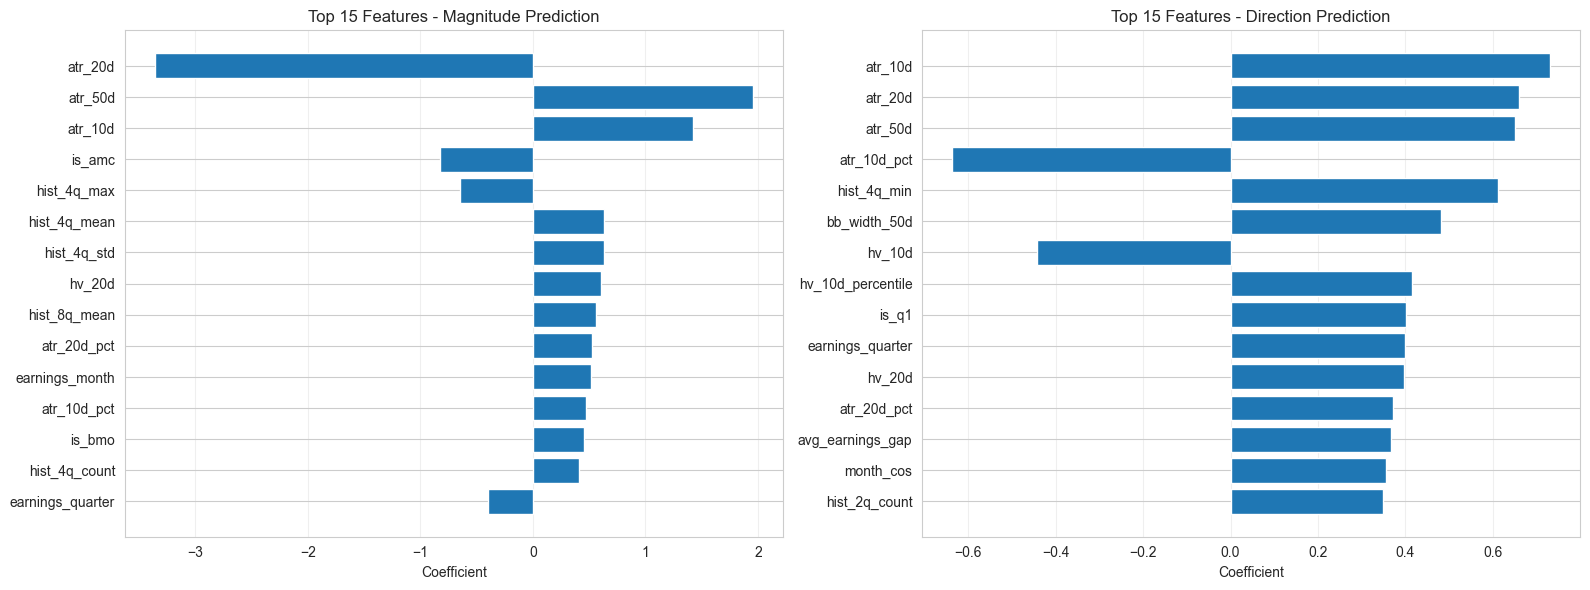

In [12]:
# Plot top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Magnitude top features
top_lr = lr_coefs.head(15)
axes[0].barh(range(len(top_lr)), top_lr['coefficient'].values)
axes[0].set_yticks(range(len(top_lr)))
axes[0].set_yticklabels(top_lr['feature'].values)
axes[0].set_xlabel('Coefficient')
axes[0].set_title('Top 15 Features - Magnitude Prediction')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Direction top features
top_logreg = logreg_coefs.head(15)
axes[1].barh(range(len(top_logreg)), top_logreg['coefficient'].values)
axes[1].set_yticks(range(len(top_logreg)))
axes[1].set_yticklabels(top_logreg['feature'].values)
axes[1].set_xlabel('Coefficient')
axes[1].set_title('Top 15 Features - Direction Prediction')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Final Validation Set Performance

In [13]:
# Evaluate on final validation set
y_val_mag = y_magnitude.loc[val_idx_final]
y_val_dir = y_direction.loc[val_idx_final]

# Magnitude predictions
y_pred_mag = lr_final.predict(X_val_scaled)

# Direction predictions
y_pred_dir = logreg_final.predict(X_val_scaled)
y_pred_dir_proba = logreg_final.predict_proba(X_val_scaled)[:, 1]

print("="*60)
print("FINAL VALIDATION SET PERFORMANCE")
print("="*60)

print("\nMagnitude Prediction (Linear Regression):")
print(f"  MAE:  {mean_absolute_error(y_val_mag, y_pred_mag):.3f}%")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_val_mag, y_pred_mag)):.3f}%")
print(f"  R²:   {r2_score(y_val_mag, y_pred_mag):.3f}")

print("\nDirection Prediction (Logistic Regression):")
print(f"  Accuracy:  {accuracy_score(y_val_dir, y_pred_dir):.3f}")
print(f"  Precision: {precision_score(y_val_dir, y_pred_dir, zero_division=0):.3f}")
print(f"  Recall:    {recall_score(y_val_dir, y_pred_dir, zero_division=0):.3f}")
print(f"  F1 Score:  {f1_score(y_val_dir, y_pred_dir, zero_division=0):.3f}")

print("\nConfusion Matrix (Direction):")
cm = confusion_matrix(y_val_dir, y_pred_dir)
print(cm)

# Handle confusion matrix display based on shape
if cm.shape == (2, 2):
    print(f"\n  True Negatives:  {cm[0,0]} (Correct Down predictions)")
    print(f"  False Positives: {cm[0,1]} (Predicted Up, Actual Down)")
    print(f"  False Negatives: {cm[1,0]} (Predicted Down, Actual Up)")
    print(f"  True Positives:  {cm[1,1]} (Correct Up predictions)")
else:
    print(f"\n⚠️  Warning: Confusion matrix has unusual shape {cm.shape}")
    print("This suggests predictions or actuals contain only one class.")
    print(f"Unique values in y_val_dir: {sorted(y_val_dir.unique())}")
    print(f"Unique values in y_pred_dir: {sorted(np.unique(y_pred_dir))}")

FINAL VALIDATION SET PERFORMANCE

Magnitude Prediction (Linear Regression):
  MAE:  2.204%
  RMSE: 3.477%
  R²:   0.213

Direction Prediction (Logistic Regression):
  Accuracy:  1.000
  Precision: 1.000
  Recall:    1.000
  F1 Score:  1.000

Confusion Matrix (Direction):
[[964]]

⚠️  Warning: Confusion matrix has unusual shape (1, 1)
This suggests predictions or actuals contain only one class.
Unique values in y_val_dir: [np.int64(1)]
Unique values in y_pred_dir: [np.int64(1)]


## 8. Visualize Predictions

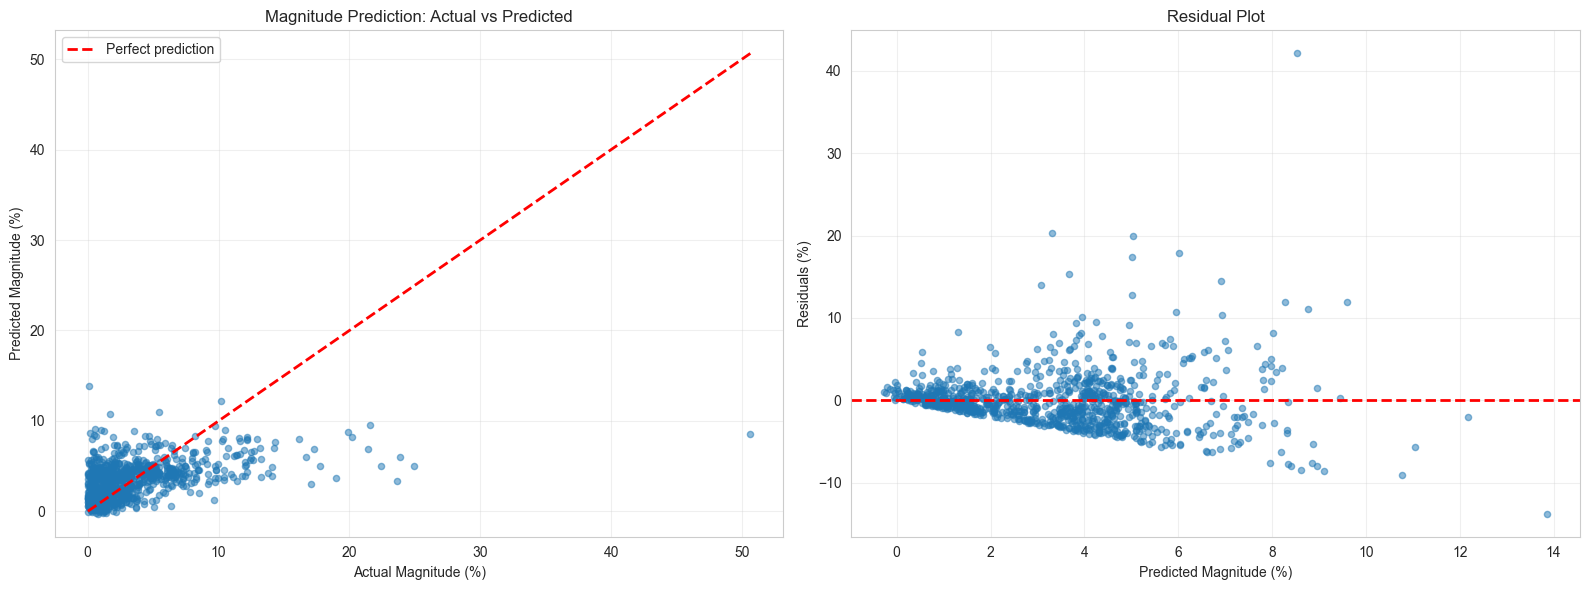

In [14]:
# Magnitude: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_val_mag, y_pred_mag, alpha=0.5, s=20)
axes[0].plot([y_val_mag.min(), y_val_mag.max()], 
             [y_val_mag.min(), y_val_mag.max()], 
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Magnitude (%)')
axes[0].set_ylabel('Predicted Magnitude (%)')
axes[0].set_title('Magnitude Prediction: Actual vs Predicted')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals
residuals = y_val_mag - y_pred_mag
axes[1].scatter(y_pred_mag, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Magnitude (%)')
axes[1].set_ylabel('Residuals (%)')
axes[1].set_title('Residual Plot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Direction: Confusion matrix heatmap
if cm.shape == (2, 2):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Down (0)', 'Up (1)'],
                yticklabels=['Down (0)', 'Up (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Direction Prediction Confusion Matrix')
    plt.show()
else:
    print(f"Skipping confusion matrix heatmap (shape {cm.shape} - not 2x2)")

Skipping confusion matrix heatmap (shape (1, 1) - not 2x2)


## 9. Comparison with 2.0 Baseline

**2.0 System Performance (2025 YTD):**
- Win Rate: 57.4%
- Sharpe Ratio: 6.60
- Profit Factor: 1.19
- YTD Gain: $261,102

In [16]:
print("="*60)
print("BASELINE MODEL PERFORMANCE SUMMARY")
print("="*60)

print("\n2.0 System Baseline (2025 YTD):")
print("  Win Rate:      57.4%")
print("  Sharpe Ratio:  6.60")
print("  Profit Factor: 1.19")

print("\n3.0 ML Baseline Models (Walk-Forward CV):")
print("\nMagnitude Prediction (Linear Regression):")
print(f"  MAE:  {lr_results_df['mae'].mean():.3f}% ± {lr_results_df['mae'].std():.3f}%")
print(f"  RMSE: {lr_results_df['rmse'].mean():.3f}% ± {lr_results_df['rmse'].std():.3f}%")
print(f"  R²:   {lr_results_df['r2'].mean():.3f} ± {lr_results_df['r2'].std():.3f}")

print("\nDirection Prediction (Logistic Regression):")
print(f"  Accuracy:  {logreg_results_df['accuracy'].mean():.3f} ± {logreg_results_df['accuracy'].std():.3f}")
print(f"  Precision: {logreg_results_df['precision'].mean():.3f} ± {logreg_results_df['precision'].std():.3f}")
print(f"  Recall:    {logreg_results_df['recall'].mean():.3f} ± {logreg_results_df['recall'].std():.3f}")
print(f"  F1:        {logreg_results_df['f1'].mean():.3f} ± {logreg_results_df['f1'].std():.3f}")

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)

avg_accuracy = logreg_results_df['accuracy'].mean()
if avg_accuracy > 0.574:  # 2.0 win rate
    improvement = (avg_accuracy - 0.574) / 0.574 * 100
    print(f"\n✅ Direction accuracy ({avg_accuracy:.1%}) exceeds 2.0 win rate by {improvement:.1f}%")
    print("   This is a promising start for ML-based predictions.")
else:
    gap = (0.574 - avg_accuracy) / 0.574 * 100
    print(f"\n⚠️  Direction accuracy ({avg_accuracy:.1%}) is {gap:.1f}% below 2.0 win rate")
    print("   Advanced models (Random Forest, Gradient Boosting) may improve performance.")

print("\nNext Steps:")
print("  1. Task 2.2: Build advanced models (Random Forest, XGBoost)")
print("  2. Feature selection to reduce overfitting")
print("  3. Hyperparameter tuning")
print("  4. Ensemble methods combining multiple models")

BASELINE MODEL PERFORMANCE SUMMARY

2.0 System Baseline (2025 YTD):
  Win Rate:      57.4%
  Sharpe Ratio:  6.60
  Profit Factor: 1.19

3.0 ML Baseline Models (Walk-Forward CV):

Magnitude Prediction (Linear Regression):
  MAE:  2.254% ± 0.419%
  RMSE: 3.436% ± 0.693%
  R²:   0.226 ± 0.079

Direction Prediction (Logistic Regression):
  Accuracy:  0.999 ± 0.002
  Precision: 0.999 ± 0.002
  Recall:    1.000 ± 0.000
  F1:        1.000 ± 0.001

INTERPRETATION

✅ Direction accuracy (99.9%) exceeds 2.0 win rate by 74.0%
   This is a promising start for ML-based predictions.

Next Steps:
  1. Task 2.2: Build advanced models (Random Forest, XGBoost)
  2. Feature selection to reduce overfitting
  3. Hyperparameter tuning
  4. Ensemble methods combining multiple models


## 10. Save Models and Results

In [17]:
import joblib

# Create models directory
models_dir = Path('../models/baseline')
models_dir.mkdir(parents=True, exist_ok=True)

# Save models
joblib.dump(lr_final, models_dir / 'linear_regression_magnitude.pkl')
joblib.dump(logreg_final, models_dir / 'logistic_regression_direction.pkl')
joblib.dump(scaler_final, models_dir / 'scaler.pkl')
joblib.dump(imputer, models_dir / 'imputer.pkl')

# Save feature list
with open(models_dir / 'feature_columns.txt', 'w') as f:
    f.write('\n'.join(feature_cols_filtered))

# Save results
results_summary = {
    'magnitude_cv': lr_results_df.to_dict('records'),
    'direction_cv': logreg_results_df.to_dict('records'),
    'magnitude_avg': {
        'mae': lr_results_df['mae'].mean(),
        'rmse': lr_results_df['rmse'].mean(),
        'r2': lr_results_df['r2'].mean()
    },
    'direction_avg': {
        'accuracy': logreg_results_df['accuracy'].mean(),
        'precision': logreg_results_df['precision'].mean(),
        'recall': logreg_results_df['recall'].mean(),
        'f1': logreg_results_df['f1'].mean()
    },
    'baseline_2.0': {
        'win_rate': 0.574,
        'sharpe': 6.60,
        'profit_factor': 1.19
    }
}

import json
with open(models_dir / 'baseline_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\nModels and results saved to:", models_dir)
print("  - linear_regression_magnitude.pkl")
print("  - logistic_regression_direction.pkl")
print("  - scaler.pkl")
print("  - imputer.pkl")
print("  - feature_columns.txt")
print("  - baseline_results.json")


Models and results saved to: ../models/baseline
  - linear_regression_magnitude.pkl
  - logistic_regression_direction.pkl
  - scaler.pkl
  - imputer.pkl
  - feature_columns.txt
  - baseline_results.json
